In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, simpledialog
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [2]:
# Calculate Angle
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return round(angle, 4)

# Browse File
def browse_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename()  # Open the file dialog
    return file_path

# Choose Video Source 
def choose_video_source():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    choice = simpledialog.askstring("Input", "Choose the source:\n1. Webcam\n2. Video file\n3. Image file", parent=root)
    return choice

# Function to process an image and display the result
def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pose = mp_pose.Pose()

    results = pose.process(image_rgb)
    landmarks = results.pose_landmarks.landmark

    # Classify the pose and get the label
    label = ClassifyPose(image_rgb, landmarks, disp=True)

    # Display the image without additional text
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [3]:
# Pose Classification
def ClassifyPose(image, landmarks, disp=False):
    label = None
    #Get Coordinates
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                  landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                  landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                   landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                    landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                 landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

    #Get Angles
    left_elbow_angle = calculate_angle(left_wrist, left_elbow, left_shoulder)
    right_elbow_angle = calculate_angle(right_wrist, right_elbow, right_shoulder)
    left_shoulder_angle = calculate_angle(left_elbow, left_shoulder, left_hip)
    right_shoulder_angle = calculate_angle(right_elbow, right_shoulder, right_hip)
    left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
    right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

    # 1. Punch
    if left_elbow_angle < 45 and right_elbow_angle < 45 and left_shoulder_angle < 40 and right_shoulder_angle < 40:
        label = "Punching"
        
    # 2. Slap
#     flag = False
#     if left_shoulder_angle > 60 and left_shoulder_angle < 120:
#         flag = True
#     if right_shoulder_angle > 60 and right_shoulder_angle < 120:
#         flag = True
#     if flag:
#         label = "Slapping"

    # 3. Warrior II Pose
    # Check if the both arms are straight.
    if left_elbow_angle > 165 and left_elbow_angle < 195 and right_elbow_angle >165 and right_elbow_angle < 195:
        # Check if shoulders are at the required angle.
        if left_shoulder_angle > 80 and left_shoulder_angle < 110 and right_shoulder_angle > 80 and right_shoulder_angle < 120:
        # Check if it is the warrior II pose.
            # Check if one leg is straight.
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
                # Check if the other leg is bended at the required angle.
                if left_knee_angle > 90 and left_knee_angle < 120 or right_knee_angle > 90 and right_knee_angle < 120:
                    # Specify the label of the pose that is Warrior II pose.
                    label = 'Warrior II Pose'
                    
    # 4. T pose
    # Check if both legs are straight
            if left_knee_angle > 160 and left_knee_angle < 195 and right_knee_angle > 160 and right_knee_angle < 195:
                # Specify the label of the pose that is tree pose.
                label = 'T Pose'
       
    # 5. Tree Pose
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle < 195:
        # Check if the other leg is bended at the required angle.
        if left_knee_angle > 315 and left_knee_angle < 335 or right_knee_angle > 25 and right_knee_angle < 45:
            # Specify the label of the pose that is tree pose.
            label = 'Tree Pose'

    if disp:
        # Display the detected pose label on the image
        cv2.putText(image, label, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    return label

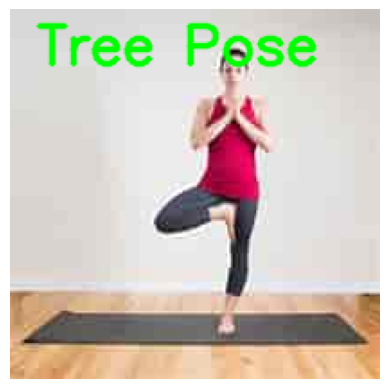

In [4]:
# Ask the user to choose the source
choice = choose_video_source()

# Initialize video capture or process image based on user's choice
if choice == '1' or choice == '2':
    cap = cv2.VideoCapture(0 if choice == '1' else browse_file())
    fps = 30 if choice == '1' else cap.get(cv2.CAP_PROP_FPS)
elif choice == '3':
    image_path = browse_file()
    process_image(image_path)
else:
    print("Invalid choice.")

# Main loop
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        if choice == '3':
            break

        ret, frame = cap.read()

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        try:
            landmarks = results.pose_landmarks.landmark

            # Classify the pose and display information
            label = ClassifyPose(image, landmarks, disp=True)

            # Display the label on the image
            cv2.putText(image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        except Exception as e:
            print(e)

        cv2.imshow('Pose Detection', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break


# Release the video capture if it was opened
if choice == '1' or choice == '2':
    cap.release()
    cv2.destroyAllWindows()